## Mutation-Based Data Matrix: Reshape data frame such that location and mutations are both represented in feature columns. Then store sparse matrix and target values into files

In [65]:
import numpy as np
from scipy import sparse 
import pandas as pd 
import matplotlib.pyplot as plt
from time import time
#import seaborn as sns
%matplotlib inline

In [186]:
# reading the raw date
df = pd.read_csv('amino_acid_genotypes_to_brightness.tsv', sep = '\t', engine = 'python')
df.head()

,aaMutations,uniqueBarcodes,medianBrightness,std
0,NaN,3645,3.719212,0.106992
1,SA108D,1,1.301030,NaN
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN
3,SA108D:SY141N:SH146L:SE220G,1,1.301189,NaN
4,SA108G,2,3.708478,0.020613


In [210]:
# Extracting brightness values and storing them separately in file
y = df[["medianBrightness","std"]].values

# save the array using numpy function numpy.savez
np.savez("target_values.npz",Brightness = y[:,0],std = y[:,1] )

# load the data using numpy.load and check the match 
loaded = np.load("target_values.npz") 
y1,std1 = loaded["Brightness"],loaded["std"]

print "Target values saved correctly?",np.isclose(y[:,0],y1).all() and np.isclose(y[:,1],std1,equal_nan=True).all()
del y,y1,std1

Target values saved correctly? True


In [205]:
#extract the column with aa mutations and split the mutations
mutants_series = df.aaMutations.str.split(':')
print mutants_series.head()

0                                         NaN
1                                    [SA108D]
2    [SA108D, SN144D, SI186V, SM231T, SL234P]
3            [SA108D, SY141N, SH146L, SE220G]
4                                    [SA108G]
Name: aaMutations, dtype: object


In [206]:
# create a list of mutants and lookup table of all unique mutations
mutants = mutants_series.tolist()
mutants[0] = [] #mutant 0 is the base case and has no mutations 

m = len(mutants)
print "Number of mutants is: %s\n"%m

mutations = {}

m_count = 0
for mutant in xrange(m):
    for mutation in mutants[mutant]:
        if mutation not in mutations:
            mutations[mutation] = {"id":m_count,"mutants":[mutant]}
            m_count += 1
        else:
            mutations[mutation]["mutants"].append(mutant)
n = len(mutations.keys())
print "Number of unique mutations is: %s\n"%n

print "Examples of using mutants and mutations "
print "Mutant %s has given mutations:%s\n"%(5,mutants[5])

print "Mutations %s is found in given mutants:%s"%("SA108D",mutations["SA108D"]["mutants"])

#mutation_df = pd.DataFrame.from_dict(mta_dic, orient='index')
#mutation_df.head()

Number of mutants is: 54025

Number of unique mutations is: 1879

Examples of using mutants and mutations 
Mutant 5 has given mutations:['SA108G', 'SK138M', 'SR166C', 'SL234P']

Mutations SA108D is found in given mutants:[1, 2, 3, 3712, 4606, 7079, 9720, 12011, 24277, 25058, 26099, 28167, 29264, 33503, 48490, 50537]


In [207]:
#creating the feature matrix in LIL format and converting it to CSR format
categ_mat_lil = sparse.lil_matrix((m,n),dtype = np.int8)
categ_mat_lil.rows.shape

t1 = time()
for i in xrange(1,m):
    cols,data = zip(*[(mutations[mutation]["id"],1.) for mutation in mutants[i]])
    categ_mat_lil.rows[i],categ_mat_lil.data[i] = list(cols),list(data)
    
categ_mat_csr = categ_mat_lil.tocsr()
del categ_mat_lil
print "Creating csr sparse matrix took %f seconds.\n"%(time()-t1)

categ_mat_csr

Creating csr sparse matrix took 0.422143 seconds.



<54025x1879 sparse matrix of type '<type 'numpy.int8'>'
	with 212388 stored elements in Compressed Sparse Row format>

In [208]:
# function to save and load csr matrices to files
def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )

def load_sparse_csr(filename):
    loader = np.load(filename)
    return sparse.csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

In [211]:
t1 = time()
save_sparse_csr('sparse_csr',categ_mat_csr)
print "Writting sparse matrix to file took %f seconds."%(time()-t1)

Writting sparse matrix to file took 0.023666 seconds.


In [215]:
test = load_sparse_csr('sparse_csr.npz')
test
print np.isclose(test.data,categ_mat_csr.data).all()
print np.isclose(test.indices,categ_mat_csr.indices).all()
print np.isclose(test.d,categ_mat_csr.data).all()

True

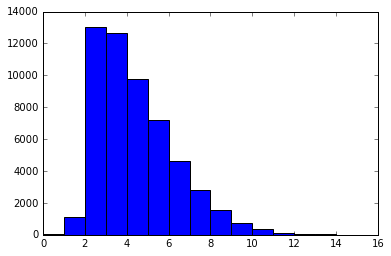

In [169]:
plt.figure()
plt.hist(categ_mat_csr.sum(axis=1), bins=15)
plt.show()